<a href="https://colab.research.google.com/github/sdesai38/5105_SD/blob/main/Hw7ConvexAIOptimizatio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install cvxpy
!pip install cvxpy[mosek]


In [ ]:
import scipy.io as sio
import numpy as np

import pandas as pd

from google.colab import drive
drive.mount('/content/drive')
filepath = '/content/drive/My Drive/ConvexAIData/Global_temp_data.mat'
dataset = sio.loadmat(filepath)

# Access the data using its key and convert it to a pandas DataFrame
temp_data = pd.DataFrame(dataset['Temperature_file'], columns=['Year', 'TemperatureAnomaly'])

# Now you can use .head()
temp_data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Year,TemperatureAnomaly
0,1881.0,-0.1350
1,1882.0,-0.1860
2,1883.0,-0.3015
3,1884.0,-0.4980
4,1885.0,-0.5910


Optimal coefficients:
x1 = 586.4213079356864
x2 = -0.6153249565118022
x3 = 0.0001612845185189928
Predicted temperature change in 2030: 1.9490185816454186


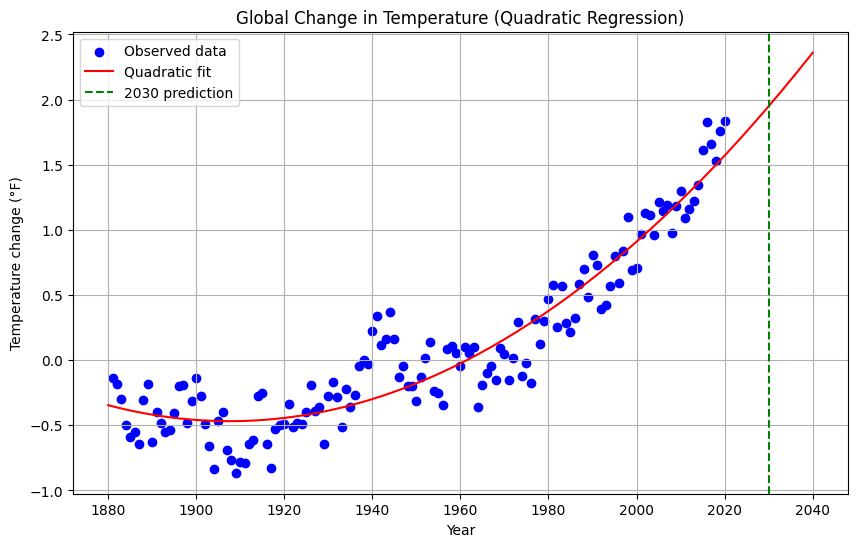

In [ ]:
import numpy as np
import scipy.io as sio
import cvxpy as cp
import matplotlib.pyplot as plt

# Load data
# data = sio.loadmat(filepath) # This loads a dictionary
# years = data[:,0]
# temp_change = data[:,1]

# Use the already loaded and processed temp_data DataFrame
years = temp_data['Year'].values
temp_change = temp_data['TemperatureAnomaly'].values

# Decision variables
x1 = cp.Variable()
x2 = cp.Variable()
x3 = cp.Variable()

# Predicted quadratic model
pred = x1 + x2*years + x3*(years**2)

# Objective: minimize squared error
objective = cp.Minimize(cp.sum_squares(temp_change - pred))

# Solve
prob = cp.Problem(objective)
prob.solve()

print("Optimal coefficients:")
print("x1 =", x1.value)
print("x2 =", x2.value)
print("x3 =", x3.value)

# Predict temperature change in 2030
year_2030 = 2030
temp_2030 = x1.value + x2.value*year_2030 + x3.value*(year_2030**2)
print("Predicted temperature change in 2030:", temp_2030)

# Plot data and fitted curve
years_span = np.arange(1880, 2041)
fit_curve = x1.value + x2.value*years_span + x3.value*(years_span**2)

plt.figure(figsize=(10,6))
plt.scatter(years, temp_change, color="blue", label="Observed data")
plt.plot(years_span, fit_curve, color="red", label="Quadratic fit")
plt.axvline(2030, color="green", linestyle="--", label="2030 prediction")
plt.xlabel("Year")
plt.ylabel("Temperature change (°F)")
plt.title("Global Change in Temperature (Quadratic Regression)")
plt.legend()
plt.grid(True)
plt.show()

Optimal total fuel cost: 18.0
Positions: [-0.  1.  2.  3.  4.  5.  6.  7.  8. 12.]
Velocities: [1. 1. 1. 1. 1. 1. 1. 1. 4. 0.]
Fuel per step: [ 1.  1.  1.  1.  1.  1.  1.  1. 10.]


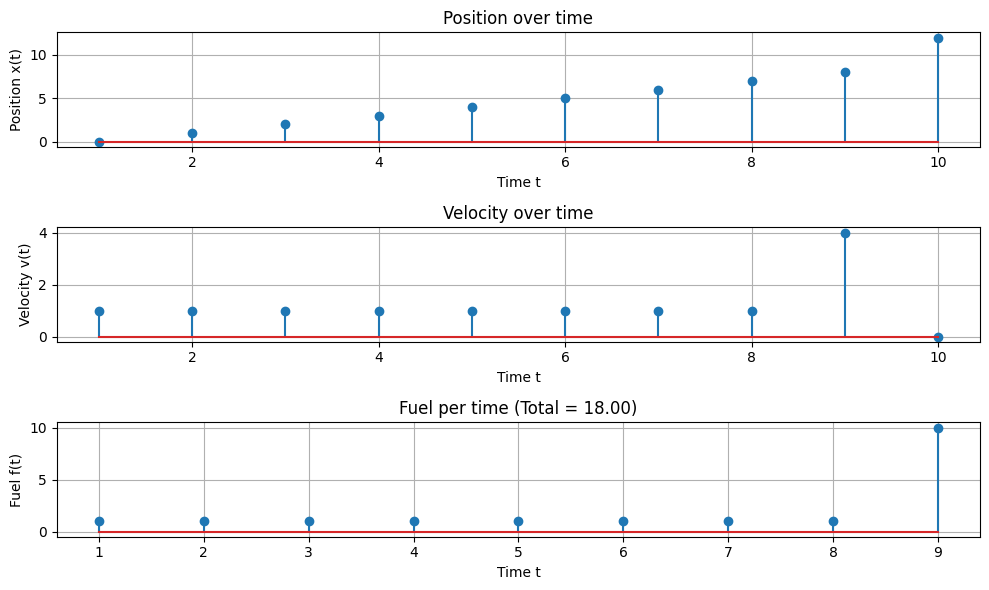

In [ ]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

# Horizon
T = 10

# Decision variables
x = cp.Variable(T)       # positions x(1..10)
v = cp.Variable(T)       # velocities v(1..10)
u = cp.Variable(T-1)     # surrogate for |v(t)|, t=1..9
f = cp.Variable(T-1)     # fuel cost per step, t=1..9

constraints = []

# Boundary conditions
constraints += [x[0] == 0]       # x(1) = 0
constraints += [x[T-1] == 12]    # x(10) = 12
constraints += [v[T-1] == 0]     # stop at final time

# Dynamics: x(t+1) = x(t) + v(t), for t=1..9
for t in range(T-1):
    constraints += [x[t+1] == x[t] + v[t]]

# Absolute value surrogate and fuel envelope
for t in range(T-1):
    constraints += [u[t] >= v[t]]
    constraints += [u[t] >= -v[t]]
    constraints += [f[t] >= u[t]]
    constraints += [f[t] >= 3*u[t] - 2]
    constraints += [u[t] >= 0, f[t] >= 0]

# Objective: minimize total fuel
objective = cp.Minimize(cp.sum(f))

# Solve
prob = cp.Problem(objective, constraints)
prob.solve(solver=cp.GLPK)  # or try solver=cp.ECOS if GLPK not installed

print("Optimal total fuel cost:", prob.value)
print("Positions:", x.value)
print("Velocities:", v.value)
print("Fuel per step:", f.value)

# Plot results
t = np.arange(1, T+1)
t_fuel = np.arange(1, T)

plt.figure(figsize=(10,6))

plt.subplot(3,1,1)
plt.stem(t, x.value)
plt.xlabel("Time t")
plt.ylabel("Position x(t)")
plt.title("Position over time")
plt.grid(True)

plt.subplot(3,1,2)
plt.stem(t, v.value)
plt.xlabel("Time t")
plt.ylabel("Velocity v(t)")
plt.title("Velocity over time")
plt.grid(True)

plt.subplot(3,1,3)
plt.stem(t_fuel, f.value)
plt.xlabel("Time t")
plt.ylabel("Fuel f(t)")
plt.title(f"Fuel per time (Total = {prob.value:.2f})")
plt.grid(True)

plt.tight_layout()
plt.show()

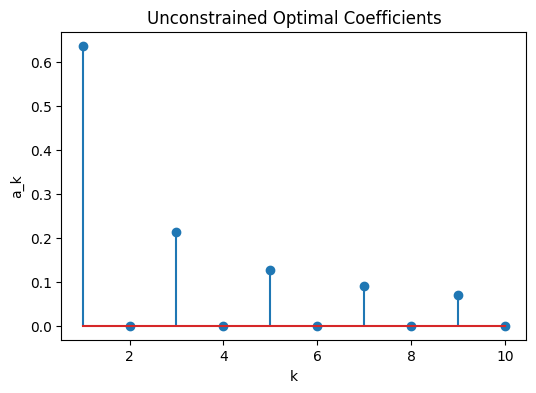

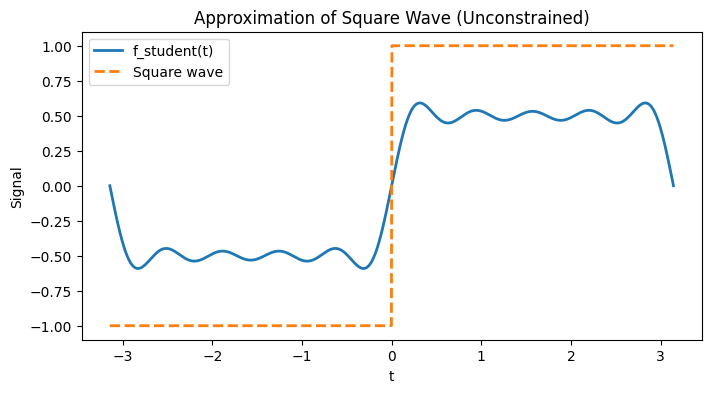

/tmp/ipython-input-4034093654.py:65: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  error_val = np.trapz((f - f_student)**2, t)


b = 1, Optimal error e = 0.7651


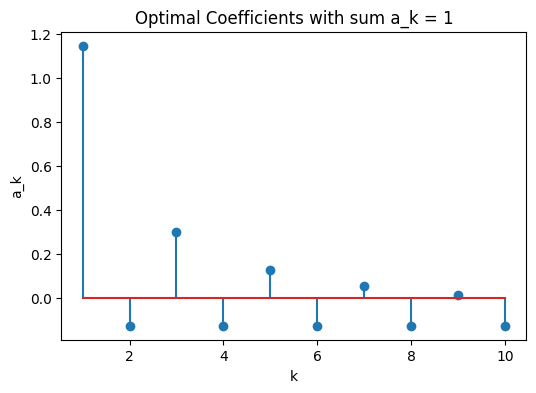

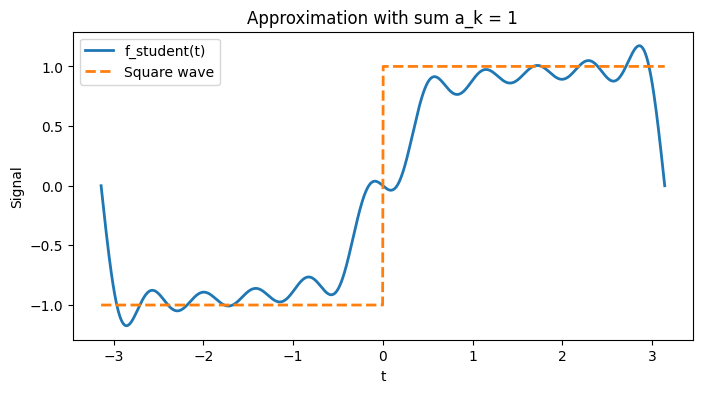

b = 3, Optimal error e = 0.4186


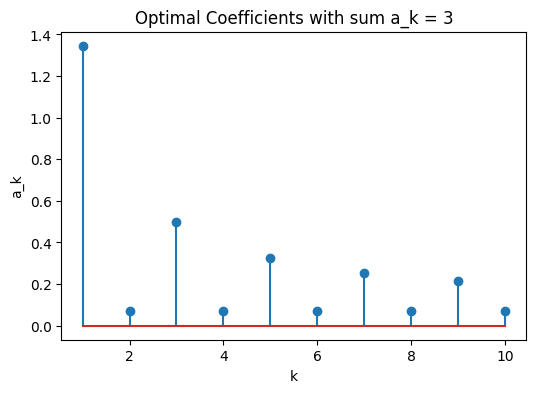

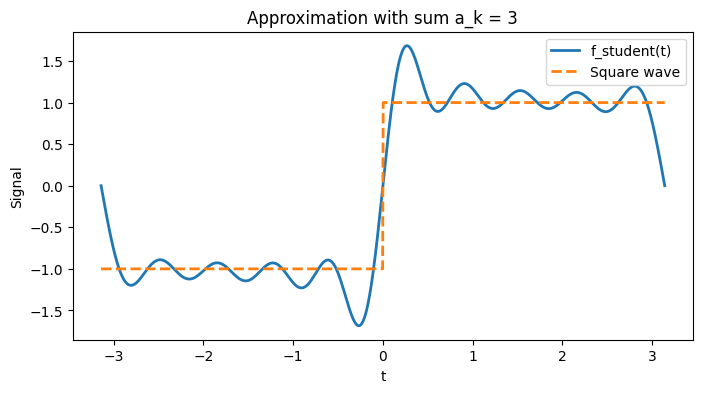

b = 5, Optimal error e = 2.5854


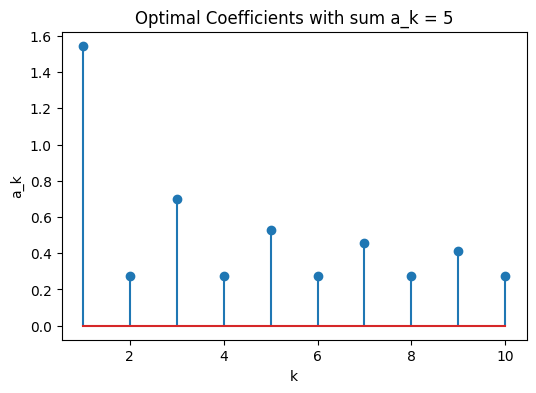

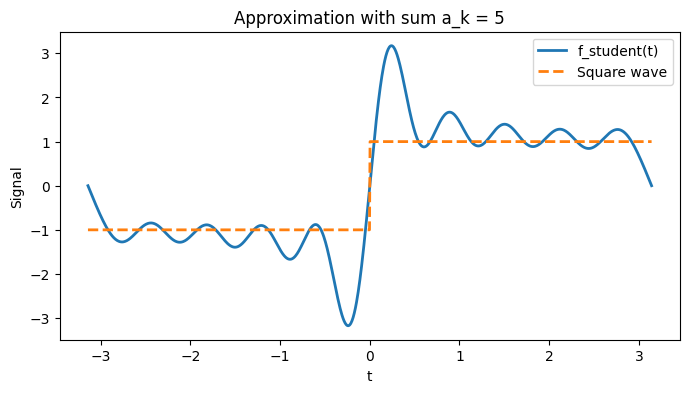

b = 10, Optimal error e = 18.9980


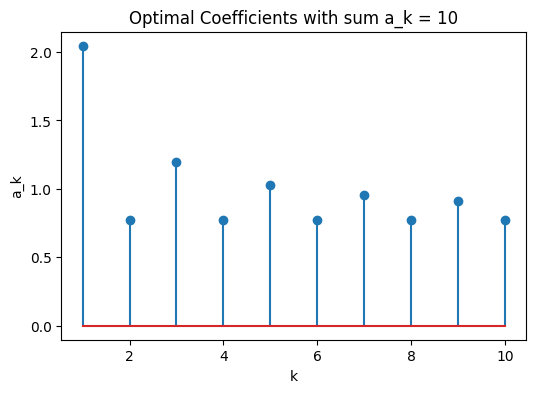

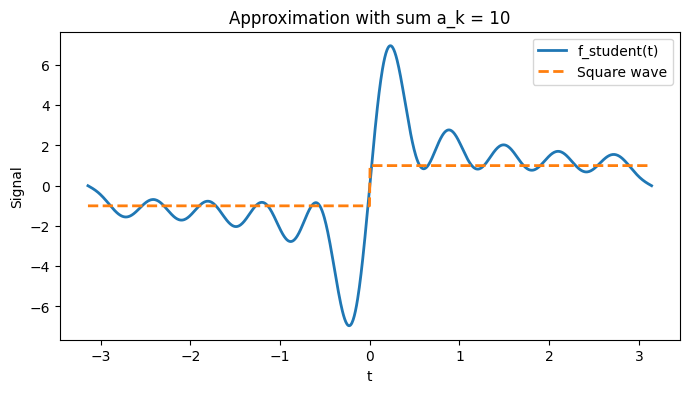

In [ ]:
# Fourier Series Approximation via Quadratic Optimization
# Ready for Google Colab

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Parameters
n = 10  # number of harmonics
Q = 2*np.pi*np.eye(n)  # quadratic term
c = np.zeros(n)

# Linear term (only odd k)
for k in range(1, n+1):
    if k % 2 == 1:
        c[k-1] = -8/k

# --- Unconstrained solution ---
a_unconstrained = -0.5 * np.linalg.solve(Q, c)

# Plot a_k vs k
plt.figure(figsize=(6,4))
plt.stem(range(1,n+1), a_unconstrained)
plt.xlabel('k'); plt.ylabel('a_k')
plt.title('Unconstrained Optimal Coefficients')
plt.show()

# Plot f_student(t) vs square wave
t = np.linspace(-np.pi, np.pi, 1000)
f_student = np.zeros_like(t)
for k in range(1,n+1):
    f_student += a_unconstrained[k-1]*np.sin(k*t)

f = np.ones_like(t)
f[t<0] = -1

plt.figure(figsize=(8,4))
plt.plot(t, f_student, label='f_student(t)', linewidth=2)
plt.plot(t, f, '--', label='Square wave', linewidth=2)
plt.xlabel('t'); plt.ylabel('Signal')
plt.legend(); plt.title('Approximation of Square Wave (Unconstrained)')
plt.show()

# --- Constrained case: sum a_k = b ---
b_values = [1,3,5,10]

def error_function(a):
    # Quadratic error function
    return np.pi*np.sum(a**2) - np.sum([(8/(k+1))*a[k] for k in range(n) if (k+1)%2==1]) + 2*np.pi

for b in b_values:
    # Constraint: sum a_k = b
    cons = {'type':'eq', 'fun': lambda a: np.sum(a) - b}

    # Initial guess
    a0 = np.zeros(n)

    res = minimize(error_function, a0, constraints=cons)
    a_constrained = res.x

    # Report optimal error
    f_student = np.zeros_like(t)
    for k in range(1,n+1):
        f_student += a_constrained[k-1]*np.sin(k*t)
    error_val = np.trapz((f - f_student)**2, t)
    print(f"b = {b}, Optimal error e = {error_val:.4f}")

    # Plot coefficients
    plt.figure(figsize=(6,4))
    plt.stem(range(1,n+1), a_constrained)
    plt.xlabel('k'); plt.ylabel('a_k')
    plt.title(f'Optimal Coefficients with sum a_k = {b}')
    plt.show()

    # Plot signal
    plt.figure(figsize=(8,4))
    plt.plot(t, f_student, label='f_student(t)', linewidth=2)
    plt.plot(t, f, '--', label='Square wave', linewidth=2)
    plt.xlabel('t'); plt.ylabel('Signal')
    plt.legend(); plt.title(f'Approximation with sum a_k = {b}')
    plt.show()


N=10: area=1.4913, length=4.0000


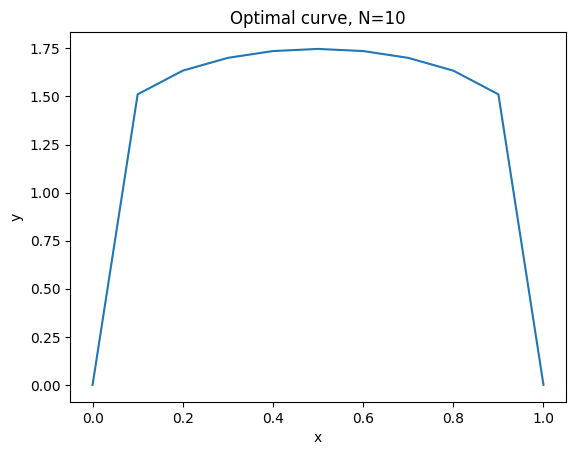

N=100: area=1.5955, length=4.0000


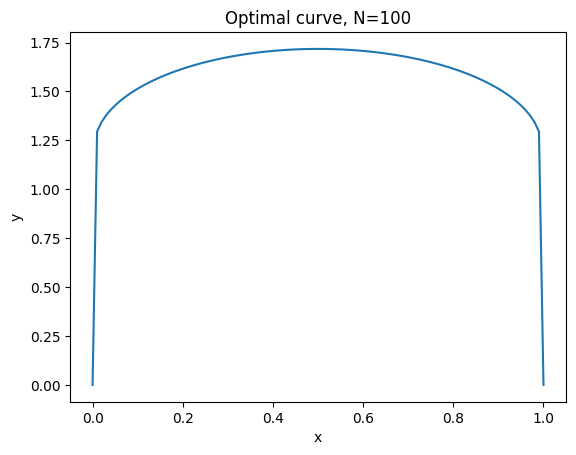

N=1000: area=1.6061, length=4.0000


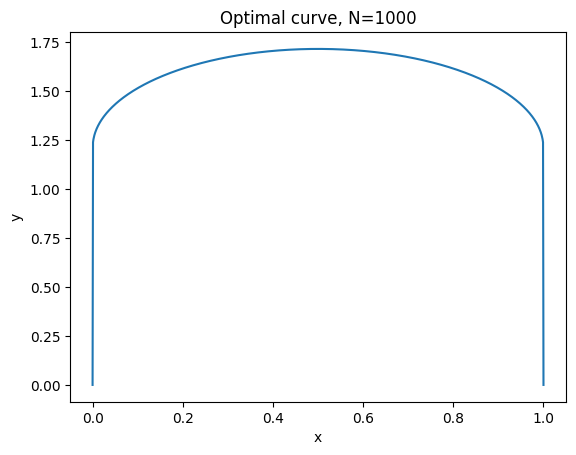

(d) N=10: area=0.1300, length=1.4142


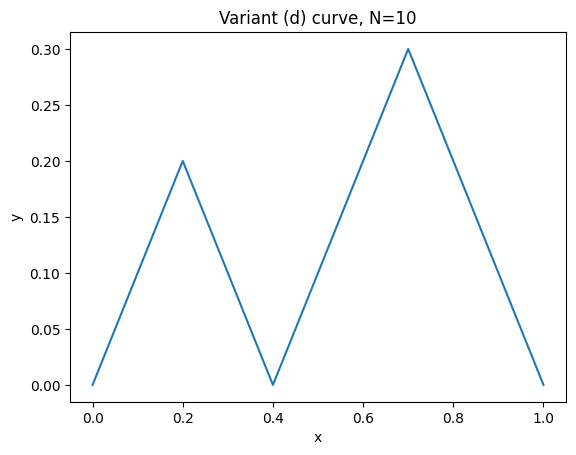

(d) N=100: area=0.1300, length=1.4146


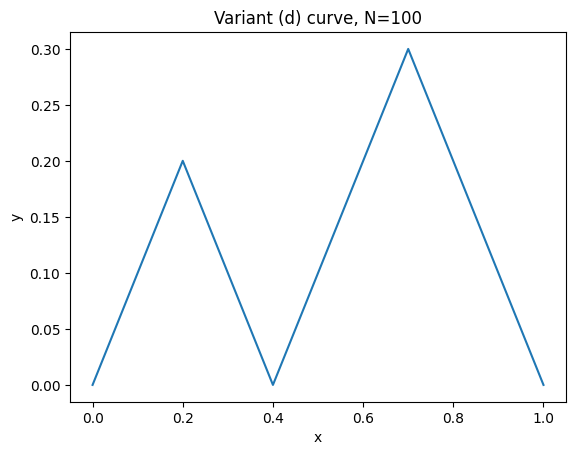

(d) N=1000: area=0.1300, length=1.4124


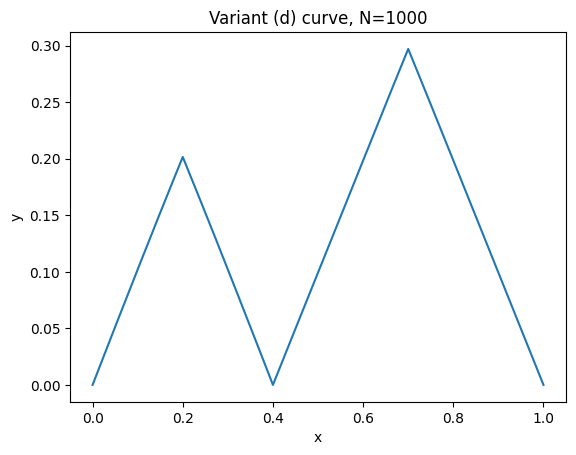

In [ ]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

def solve_and_plot(N, with_mid_touch=False, slope_bound=False):
    dx = 1.0 / N
    y = cp.Variable(N+1)
    t = cp.Variable(N)
    constraints = [y[0] == 0, y[N] == 0, cp.sum(t) <= 4]
    for i in range(N):
        constraints += [cp.norm(cp.hstack([dx, y[i+1] - y[i]]), 2) <= t[i]]
    # Optional constraints
    if with_mid_touch:
        mid = int(0.4 * N)
        constraints += [y[mid] == 0]
    if slope_bound:
        # |(y[i+1]-y[i])/dx| <= 1  =>  |y[i+1]-y[i]| <= dx
        for i in range(N):
            constraints += [y[i+1] - y[i] <= dx, y[i+1] - y[i] >= -dx]

    # Objective: maximize area (trapezoids -> simplifies to (1/N)*sum y[1:N-1] since y[0]=y[N]=0)
    obj = cp.Maximize((1.0 / N) * cp.sum(y[1:N]))
    prob = cp.Problem(obj, constraints)
    prob.solve(solver=cp.SCS, verbose=False)  # Using SCS as MOSEK is not installed

    # Compute area and length from solution
    yv = y.value
    A = (1.0 / (2*N)) * (yv[0] + 2*np.sum(yv[1:N]) + yv[N])  # trapezoidal
    L = np.sum(np.sqrt(dx**2 + np.diff(yv)**2))
    x = np.linspace(0, 1, N+1)
    return x, yv, A, L

# Example runs and plots
for N in [10, 100, 1000]:
    x, yv, A, L = solve_and_plot(N)
    print(f"N={N}: area={A:.4f}, length={L:.4f}")
    plt.figure()
    plt.plot(x, yv, '-')
    plt.title(f"Optimal curve, N={N}")
    plt.xlabel("x"); plt.ylabel("y")
    plt.show()

# Variant (d)
for N in [10, 100, 1000]:
    x, yv, A, L = solve_and_plot(N, with_mid_touch=True, slope_bound=True)
    print(f"(d) N={N}: area={A:.4f}, length={L:.4f}")
    plt.figure()
    plt.plot(x, yv, '-')
    plt.title(f"Variant (d) curve, N={N}")
    plt.xlabel("x"); plt.ylabel("y")
    plt.show()


Optimal cost: 8.969698843304888e-17


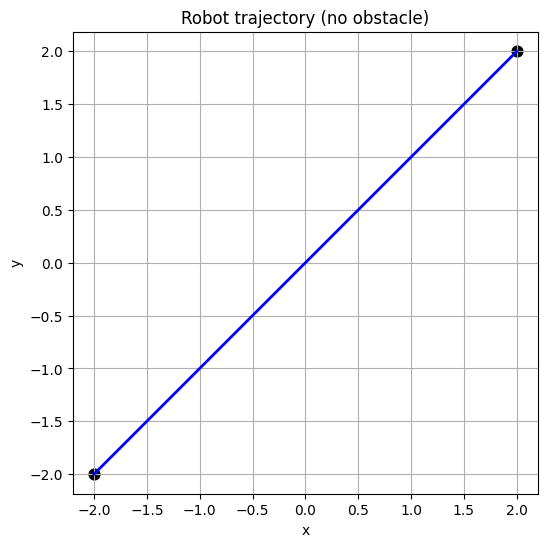

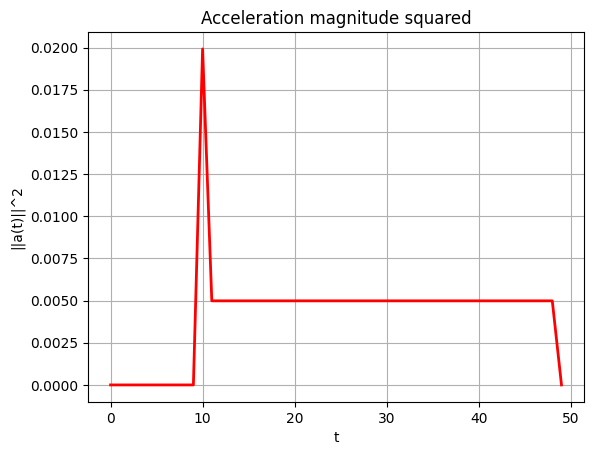

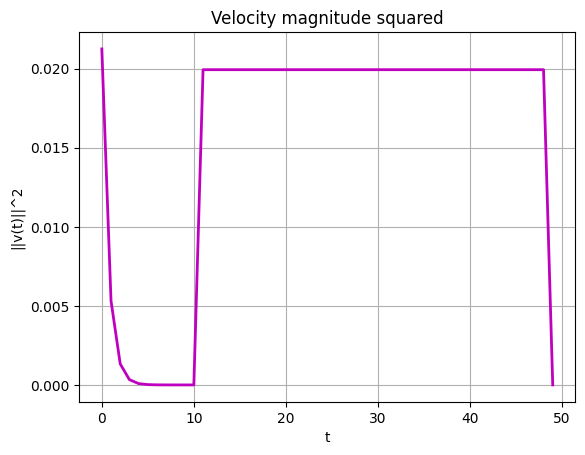

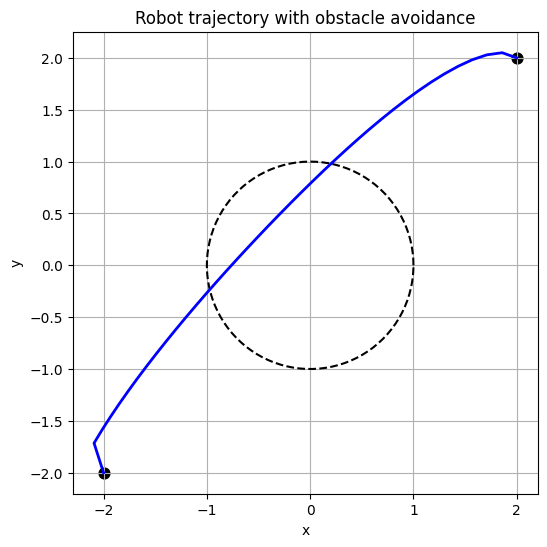

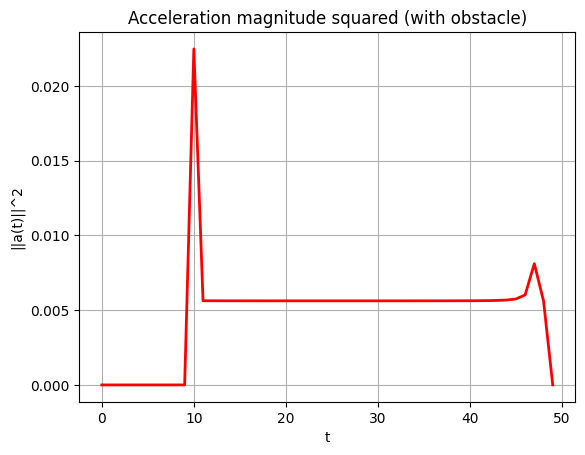

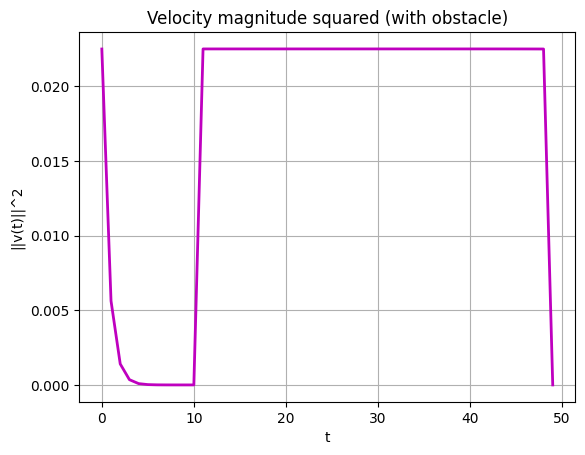

In [ ]:
# Install cvxpy and ecos
!pip install cvxpy ecos

import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

# Parameters
T   = 50
rho = 0.5

# Variables
x = cp.Variable((2, T))
v = cp.Variable((2, T))
a = cp.Variable((2, T))

constraints = []

# Boundary conditions
constraints += [x[:,0] == np.array([-2, -2])]
constraints += [x[:,T-1] == np.array([2, 2])]
constraints += [v[:,T-1] == np.array([0, 0])]

# Dynamics
for t in range(T-1):
    constraints += [x[:,t+1] == x[:,t] + v[:,t]]
    constraints += [v[:,t+1] == rho * v[:,t] + a[:,t]]

# Velocity magnitude constraint
for t in range(T):
    constraints += [cp.norm(v[:,t], 2) <= 0.15]

# Objective: minimize sum of squared acceleration over first 10 steps
objective = cp.Minimize(cp.sum_squares(a[:,:10]))

# Solve using CLARABEL (Modern replacement for ECOS, high precision)
prob = cp.Problem(objective, constraints)
prob.solve(solver=cp.CLARABEL)

print("Optimal cost:", prob.value)

# Extract values
x_val = x.value
v_val = v.value
a_val = a.value

# Plot trajectory
plt.figure(figsize=(6,6))
plt.plot(x_val[0,:], x_val[1,:], 'b-', linewidth=2)
plt.scatter([-2,2], [-2,2], c='k', s=60)
plt.xlabel('x'); plt.ylabel('y'); plt.title('Robot trajectory (no obstacle)')
plt.grid(True); plt.axis('equal')
plt.show()

# Plot acceleration magnitude squared
plt.figure()
plt.plot(np.sum(a_val**2, axis=0), 'r-', linewidth=2)
plt.xlabel('t'); plt.ylabel('||a(t)||^2'); plt.title('Acceleration magnitude squared')
plt.grid(True)
plt.show()

# Plot velocity magnitude squared
plt.figure()
plt.plot(np.sum(v_val**2, axis=0), 'm-', linewidth=2)
plt.xlabel('t'); plt.ylabel('||v(t)||^2'); plt.title('Velocity magnitude squared')
plt.grid(True)
plt.show()


###b

# Iterative convexification for obstacle avoidance
x_feas = x_val.copy()

for k in range(15):
    x = cp.Variable((2, T))
    v = cp.Variable((2, T))
    a = cp.Variable((2, T))
    constraints = []

    # Boundary conditions
    constraints += [x[:,0] == np.array([-2, -2])]
    constraints += [x[:,T-1] == np.array([2, 2])]
    constraints += [v[:,T-1] == np.array([0, 0])]

    # Dynamics
    for t in range(T-1):
        constraints += [x[:,t+1] == x[:,t] + v[:,t]]
        constraints += [v[:,t+1] == rho * v[:,t] + a[:,t]]

    # Velocity magnitude constraint
    for t in range(T):
        constraints += [cp.norm(v[:,t], 2) <= 0.15]

    # Obstacle avoidance surrogate
    for t in range(T):
        constraints += [x[:,t] @ x_feas[:,t] >= np.dot(x_feas[:,t], x_feas[:,t])]

    # Objective
    objective = cp.Minimize(cp.sum_squares(a[:,:10]))

    # Solve using CLARABEL
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.CLARABEL)

    x_feas = x.value.copy()

# Final solution
x_val = x.value
v_val = v.value
a_val = a.value

# Plot trajectory with obstacle
theta = np.linspace(0, 2*np.pi, 200)
circle = np.vstack((np.cos(theta), np.sin(theta)))

plt.figure(figsize=(6,6))
plt.plot(circle[0,:], circle[1,:], 'k--', linewidth=1.5) # obstacle boundary
plt.plot(x_val[0,:], x_val[1,:], 'b-', linewidth=2)
plt.scatter([-2,2], [-2,2], c='k', s=60)
plt.xlabel('x'); plt.ylabel('y'); plt.title('Robot trajectory with obstacle avoidance')
plt.grid(True); plt.axis('equal')
plt.show()

# Plot acceleration magnitude squared
plt.figure()
plt.plot(np.sum(a_val**2, axis=0), 'r-', linewidth=2)
plt.xlabel('t'); plt.ylabel('||a(t)||^2'); plt.title('Acceleration magnitude squared (with obstacle)')
plt.grid(True)
plt.show()

# Plot velocity magnitude squared
plt.figure()
plt.plot(np.sum(v_val**2, axis=0), 'm-', linewidth=2)
plt.xlabel('t'); plt.ylabel('||v(t)||^2'); plt.title('Velocity magnitude squared (with obstacle)')
plt.grid(True)
plt.show()

###c

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  coinor-libcbc3 coinor-libcgl1 coinor-libclp1 coinor-libcoinutils3v5
  coinor-libosi1v5 libamd2 libcolamd2 libglpk40 libsuitesparseconfig5
Suggested packages:
  libiodbc2-dev
The following NEW packages will be installed:
  coinor-cbc coinor-libcbc3 coinor-libcgl1 coinor-libclp1
  coinor-libcoinutils3v5 coinor-libosi1v5 glpk-utils libamd2 libcolamd2
  libglpk40 libsuitesparseconfig5
0 upgraded, 11 newly installed, 0 to remove and 41 not upgraded.
Need to get 3,533 kB of archives.
After this operation, 10.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libsuitesparseconfig5 amd64 1:5.10.1+dfsg-4build1 [10.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libamd2 amd64 1:5.10.1+dfsg-4build1 [21.6 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libcolamd2 amd64 1

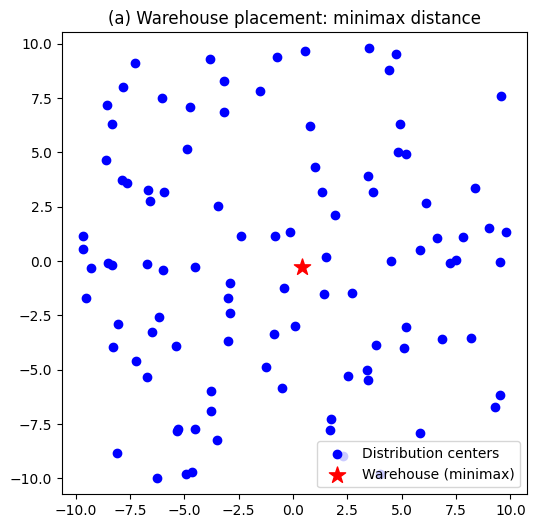

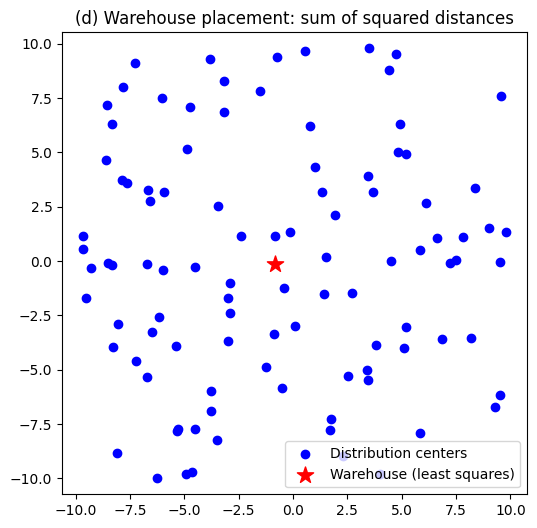

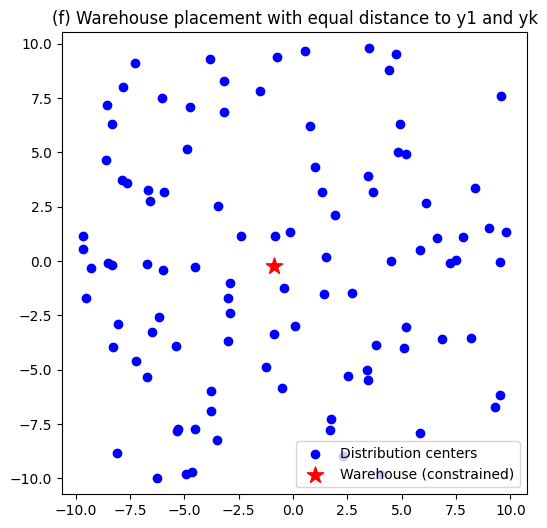

In [ ]:
# ============================
# Urban Planning Optimization
# ============================

# --- Install dependencies ---
!pip install cvxpy
!apt-get install -y coinor-cbc glpk-utils

import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

# --- Hardcoded distribution centers (Y) ---
Y = np.array([
 [5.1892, 4.9182],
 [-6.2582, -9.9961],
 [9.2856, -6.7126],
 [3.8159, -3.8430],
 [-0.7162, 9.3648],
 [9.7975, 1.3436],
 [5.8592, 0.5274],
 [-4.5179, -7.7148],
 [-8.2618, -3.9557],
 [-8.5382, 7.1998],
 [4.8148, 5.0107],
 [4.4148, 8.8019],
 [3.4901, 9.7922],
 [-1.2353, -4.8719],
 [-3.7985, 9.2956],
 [9.5281, -6.1659],
 [4.5141, -0.0079],
 [5.8569, -7.9005],
 [-7.6192, 3.5865],
 [-2.9724, -3.6631],
 [-3.1731, 8.2948],
 [1.7561, -7.2687],
 [9.5830, 7.5948],
 [8.2045, -3.5605],
 [-9.6376, 1.1304],
 [-7.8641, 3.7426],
 [-4.6264, -9.7061],
 [5.0857, -4.0104],
 [-3.7861, -5.9684],
 [6.8576, -3.6012],
 [4.7532, 9.5084],
 [-4.7456, 7.0748],
 [-8.1116, -8.8189],
 [-6.7254, -0.1332],
 [-0.1400, 1.3349],
 [-6.4999, -3.2488],
 [-5.9143, 3.1969],
 [9.5451, -0.0586],
 [-2.8912, -2.3936],
 [-2.9094, -1.0082],
 [-4.5224, -0.2581],
 [-3.0031, -1.7002],
 [0.0736, -2.9848],
 [-6.6884, 3.2629],
 [-8.4946, -0.0733],
 [1.0363, 4.3463],
 [-9.6453, 0.5744],
 [1.3184, 3.1713],
 [-5.3636, -3.9218],
 [-7.8363, 8.0208],
 [-2.3678, 1.1625],
 [-5.2862, -7.7013],
 [6.1157, 2.6632],
 [-3.4602, 2.5327],
 [3.3937, -5.0216],
 [-0.4894, -5.8399],
 [1.9132, 2.1162],
 [-8.6206, 4.6662],
 [-0.8370, 1.1563],
 [-5.9614, -0.4306],
 [5.2028, -3.0303],
 [7.5135, 0.0718],
 [-8.0573, -2.9015],
 [4.0195, -9.8140],
 [-5.3117, -7.8094],
 [-3.4940, -8.2078],
 [0.8070, 6.2192],
 [-8.3048, -0.1979],
 [-9.2940, -0.3312],
 [-8.3404, 6.2962],
 [3.6932, 3.1746],
 [4.9033, 6.3164],
 [-4.8890, 5.1398],
 [3.4749, -5.4682],
 [6.6142, 1.0511],
 [-7.1997, -4.6142],
 [2.2982, -8.9515],
 [-3.7891, -6.8879],
 [-6.5555, 2.7620],
 [2.7172, -1.4810],
 [-1.4933, 7.8087],
 [-6.6923, -5.3332],
 [2.5136, -5.3009],
 [-0.4269, -1.2427],
 [1.4210, -1.4951],
 [7.8332, 1.1002],
 [-6.0197, 7.4867],
 [-9.5084, -1.7117],
 [3.4459, 3.9012],
 [-3.1783, 6.8749],
 [-7.2497, 9.0925],
 [-6.1456, -2.5891],
 [9.0057, 1.5410],
 [-4.8994, -9.7855],
 [1.5142, 0.2032],
 [7.2310, -0.0718],
 [8.3829, 3.3423],
 [-0.8855, -3.3398],
 [0.5336, 9.6796],
 [1.6889, -7.7510]
])

k = Y.shape[0]

# -----------------------------
# (a) Minimize worst-case distance
# -----------------------------
x = cp.Variable(2)
t = cp.Variable()

constraints = [cp.norm(x - Y[i,:], 2) <= t for i in range(k)]
objective = cp.Minimize(t)
prob = cp.Problem(objective, constraints)
prob.solve(solver=cp.CLARABEL)

x_minimax = x.value

plt.figure(figsize=(6,6))
plt.scatter(Y[:,0], Y[:,1], c='blue', label='Distribution centers')
plt.scatter(x_minimax[0], x_minimax[1], c='red', marker='*', s=150, label='Warehouse (minimax)')
plt.legend(); plt.title("(a) Warehouse placement: minimax distance")
plt.axis('equal'); plt.show()

# -----------------------------
# (d) Minimize sum of squared distances
# -----------------------------
x_mean = np.mean(Y, axis=0)

plt.figure(figsize=(6,6))
plt.scatter(Y[:,0], Y[:,1], c='blue', label='Distribution centers')
plt.scatter(x_mean[0], x_mean[1], c='red', marker='*', s=150, label='Warehouse (least squares)')
plt.legend(); plt.title("(d) Warehouse placement: sum of squared distances")
plt.axis('equal'); plt.show()

# -----------------------------
# (f) Constrained least squares
# Equal distance to y1 and yk
# -----------------------------
a = Y[0,:]
b = Y[-1,:]
n = b - a
c = (np.dot(b,b) - np.dot(a,a)) / 2
m = np.mean(Y, axis=0)

# Projection of mean onto hyperplane n^T x = c
x_proj = m - ((np.dot(n, m) - c) / np.dot(n, n)) * n

plt.figure(figsize=(6,6))
plt.scatter(Y[:,0], Y[:,1], c='blue', label='Distribution centers')
plt.scatter(x_proj[0], x_proj[1], c='red', marker='*', s=150, label='Warehouse (constrained)')
plt.legend(); plt.title("(f) Warehouse placement with equal distance to y1 and yk")
plt.axis('equal'); plt.show()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
coinor-cbc is already the newest version (2.10.7+ds1-1).
glpk-utils is already the newest version (5.0-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
Optimal warehouse location (x*): [ 0.40183486 -0.25213053]
Optimal worst-case distance (t*): 12.077587175500472


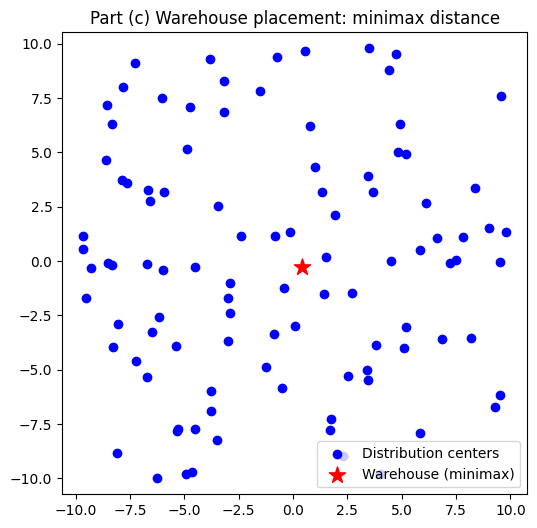

In [ ]:
# --- Install dependencies ---
!pip install cvxpy
!pip install ecos
!apt-get install -y coinor-cbc glpk-utils

import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

# --- Hardcoded distribution centers (Y) ---
Y = np.array([
 [5.1892, 4.9182],
 [-6.2582, -9.9961],
 [9.2856, -6.7126],
 [3.8159, -3.8430],
 [-0.7162, 9.3648],
 [9.7975, 1.3436],
 [5.8592, 0.5274],
 [-4.5179, -7.7148],
 [-8.2618, -3.9557],
 [-8.5382, 7.1998],
 [4.8148, 5.0107],
 [4.4148, 8.8019],
 [3.4901, 9.7922],
 [-1.2353, -4.8719],
 [-3.7985, 9.2956],
 [9.5281, -6.1659],
 [4.5141, -0.0079],
 [5.8569, -7.9005],
 [-7.6192, 3.5865],
 [-2.9724, -3.6631],
 [-3.1731, 8.2948],
 [1.7561, -7.2687],
 [9.5830, 7.5948],
 [8.2045, -3.5605],
 [-9.6376, 1.1304],
 [-7.8641, 3.7426],
 [-4.6264, -9.7061],
 [5.0857, -4.0104],
 [-3.7861, -5.9684],
 [6.8576, -3.6012],
 [4.7532, 9.5084],
 [-4.7456, 7.0748],
 [-8.1116, -8.8189],
 [-6.7254, -0.1332],
 [-0.1400, 1.3349],
 [-6.4999, -3.2488],
 [-5.9143, 3.1969],
 [9.5451, -0.0586],
 [-2.8912, -2.3936],
 [-2.9094, -1.0082],
 [-4.5224, -0.2581],
 [-3.0031, -1.7002],
 [0.0736, -2.9848],
 [-6.6884, 3.2629],
 [-8.4946, -0.0733],
 [1.0363, 4.3463],
 [-9.6453, 0.5744],
 [1.3184, 3.1713],
 [-5.3636, -3.9218],
 [-7.8363, 8.0208],
 [-2.3678, 1.1625],
 [-5.2862, -7.7013],
 [6.1157, 2.6632],
 [-3.4602, 2.5327],
 [3.3937, -5.0216],
 [-0.4894, -5.8399],
 [1.9132, 2.1162],
 [-8.6206, 4.6662],
 [-0.8370, 1.1563],
 [-5.9614, -0.4306],
 [5.2028, -3.0303],
 [7.5135, 0.0718],
 [-8.0573, -2.9015],
 [4.0195, -9.8140],
 [-5.3117, -7.8094],
 [-3.4940, -8.2078],
 [0.8070, 6.2192],
 [-8.3048, -0.1979],
 [-9.2940, -0.3312],
 [-8.3404, 6.2962],
 [3.6932, 3.1746],
 [4.9033, 6.3164],
 [-4.8890, 5.1398],
 [3.4749, -5.4682],
 [6.6142, 1.0511],
 [-7.1997, -4.6142],
 [2.2982, -8.9515],
 [-3.7891, -6.8879],
 [-6.5555, 2.7620],
 [2.7172, -1.4810],
 [-1.4933, 7.8087],
 [-6.6923, -5.3332],
 [2.5136, -5.3009],
 [-0.4269, -1.2427],
 [1.4210, -1.4951],
 [7.8332, 1.1002],
 [-6.0197, 7.4867],
 [-9.5084, -1.7117],
 [3.4459, 3.9012],
 [-3.1783, 6.8749],
 [-7.2497, 9.0925],
 [-6.1456, -2.5891],
 [9.0057, 1.5410],
 [-4.8994, -9.7855],
 [1.5142, 0.2032],
 [7.2310, -0.0718],
 [8.3829, 3.3423],
 [-0.8855, -3.3398],
 [0.5336, 9.6796],
 [1.6889, -7.7510]
])

k = Y.shape[0]

# --- Define variables ---
x = cp.Variable(2)
t = cp.Variable()

# --- Constraints: all distances <= t ---
constraints = [cp.norm(x - Y[i,:], 2) <= t for i in range(k)]
objective = cp.Minimize(t)
prob = cp.Problem(objective, constraints)

# --- Solve ---
prob.solve(solver=cp.CLARABEL)  # ECOS handles SOCP well

print("Optimal warehouse location (x*):", x.value)
print("Optimal worst-case distance (t*):", t.value)

# --- Plot ---
plt.figure(figsize=(6,6))
plt.scatter(Y[:,0], Y[:,1], c='blue', label='Distribution centers')
plt.scatter(x.value[0], x.value[1], c='red', marker='*', s=150, label='Warehouse (minimax)')
plt.legend(); plt.title("Part (c) Warehouse placement: minimax distance")
plt.axis('equal'); plt.show()


In [ ]:
import numpy as np

# Hardcoded Y from your dataset
Y = np.array([
 [5.1892, 4.9182],
 [-6.2582, -9.9961],
 [9.2856, -6.7126],
 [3.8159, -3.8430],
 [-0.7162, 9.3648],
 [9.7975, 1.3436],
 [5.8592, 0.5274],
 [-4.5179, -7.7148],
 [-8.2618, -3.9557],
 [-8.5382, 7.1998],
 [4.8148, 5.0107],
 [4.4148, 8.8019],
 [3.4901, 9.7922],
 [-1.2353, -4.8719],
 [-3.7985, 9.2956],
 [9.5281, -6.1659],
 [4.5141, -0.0079],
 [5.8569, -7.9005],
 [-7.6192, 3.5865],
 [-2.9724, -3.6631],
 [-3.1731, 8.2948],
 [1.7561, -7.2687],
 [9.5830, 7.5948],
 [8.2045, -3.5605],
 [-9.6376, 1.1304],
 [-7.8641, 3.7426],
 [-4.6264, -9.7061],
 [5.0857, -4.0104],
 [-3.7861, -5.9684],
 [6.8576, -3.6012],
 [4.7532, 9.5084],
 [-4.7456, 7.0748],
 [-8.1116, -8.8189],
 [-6.7254, -0.1332],
 [-0.1400, 1.3349],
 [-6.4999, -3.2488],
 [-5.9143, 3.1969],
 [9.5451, -0.0586],
 [-2.8912, -2.3936],
 [-2.9094, -1.0082],
 [-4.5224, -0.2581],
 [-3.0031, -1.7002],
 [0.0736, -2.9848],
 [-6.6884, 3.2629],
 [-8.4946, -0.0733],
 [1.0363, 4.3463],
 [-9.6453, 0.5744],
 [1.3184, 3.1713],
 [-5.3636, -3.9218],
 [-7.8363, 8.0208],
 [-2.3678, 1.1625],
 [-5.2862, -7.7013],
 [6.1157, 2.6632],
 [-3.4602, 2.5327],
 [3.3937, -5.0216],
 [-0.4894, -5.8399],
 [1.9132, 2.1162],
 [-8.6206, 4.6662],
 [-0.8370, 1.1563],
 [-5.9614, -0.4306],
 [5.2028, -3.0303],
 [7.5135, 0.0718],
 [-8.0573, -2.9015],
 [4.0195, -9.8140],
 [-5.3117, -7.8094],
 [-3.4940, -8.2078],
 [0.8070, 6.2192],
 [-8.3048, -0.1979],
 [-9.2940, -0.3312],
 [-8.3404, 6.2962],
 [3.6932, 3.1746],
 [4.9033, 6.3164],
 [-4.8890, 5.1398],
 [3.4749, -5.4682],
 [6.6142, 1.0511],
 [-7.1997, -4.6142],
 [2.2982, -8.9515],
 [-3.7891, -6.8879],
 [-6.5555, 2.7620],
 [2.7172, -1.4810],
 [-1.4933, 7.8087],
 [-6.6923, -5.3332],
 [2.5136, -5.3009],
 [-0.4269, -1.2427],
 [1.4210, -1.4951],
 [7.8332, 1.1002],
 [-6.0197, 7.4867],
 [-9.5084, -1.7117],
 [3.4459, 3.9012],
 [-3.1783, 6.8749],
 [-7.2497, 9.0925],
 [-6.1456, -2.5891],
 [9.0057, 1.5410],
 [-4.8994, -9.7855],
 [1.5142, 0.2032],
 [7.2310, -0.0718],
 [8.3829, 3.3423],
 [-0.8855, -3.3398],
 [0.5336, 9.6796],
 [1.6889, -7.7510]
])

x_mean = np.mean(Y, axis=0)
print("Part (d) warehouse location (centroid):", x_mean)


Part (d) warehouse location (centroid): [-0.842372 -0.134029]


In [ ]:
import numpy as np

Y = np.array([
 [5.1892, 4.9182],
 [-6.2582, -9.9961],
 [9.2856, -6.7126],
 [3.8159, -3.8430],
 [-0.7162, 9.3648],
 [9.7975, 1.3436],
 [5.8592, 0.5274],
 [-4.5179, -7.7148],
 [-8.2618, -3.9557],
 [-8.5382, 7.1998],
 [4.8148, 5.0107],
 [4.4148, 8.8019],
 [3.4901, 9.7922],
 [-1.2353, -4.8719],
 [-3.7985, 9.2956],
 [9.5281, -6.1659],
 [4.5141, -0.0079],
 [5.8569, -7.9005],
 [-7.6192, 3.5865],
 [-2.9724, -3.6631],
 [-3.1731, 8.2948],
 [1.7561, -7.2687],
 [9.5830, 7.5948],
 [8.2045, -3.5605],
 [-9.6376, 1.1304],
 [-7.8641, 3.7426],
 [-4.6264, -9.7061],
 [5.0857, -4.0104],
 [-3.7861, -5.9684],
 [6.8576, -3.6012],
 [4.7532, 9.5084],
 [-4.7456, 7.0748],
 [-8.1116, -8.8189],
 [-6.7254, -0.1332],
 [-0.1400, 1.3349],
 [-6.4999, -3.2488],
 [-5.9143, 3.1969],
 [9.5451, -0.0586],
 [-2.8912, -2.3936],
 [-2.9094, -1.0082],
 [-4.5224, -0.2581],
 [-3.0031, -1.7002],
 [0.0736, -2.9848],
 [-6.6884, 3.2629],
 [-8.4946, -0.0733],
 [1.0363, 4.3463],
 [-9.6453, 0.5744],
 [1.3184, 3.1713],
 [-5.3636, -3.9218],
 [-7.8363, 8.0208],
 [-2.3678, 1.1625],
 [-5.2862, -7.7013],
 [6.1157, 2.6632],
 [-3.4602, 2.5327],
 [3.3937, -5.0216],
 [-0.4894, -5.8399],
 [1.9132, 2.1162],
 [-8.6206, 4.6662],
 [-0.8370, 1.1563],
 [-5.9614, -0.4306],
 [5.2028, -3.0303],
 [7.5135, 0.0718],
 [-8.0573, -2.9015],
 [4.0195, -9.8140],
 [-5.3117, -7.8094],
 [-3.4940, -8.2078],
 [0.8070, 6.2192],
 [-8.3048, -0.1979],
 [-9.2940, -0.3312],
 [-8.3404, 6.2962],
 [3.6932, 3.1746],
 [4.9033, 6.3164],
 [-4.8890, 5.1398],
 [3.4749, -5.4682],
 [6.6142, 1.0511],
 [-7.1997, -4.6142],
 [2.2982, -8.9515],
 [-3.7891, -6.8879],
 [-6.5555, 2.7620],
 [2.7172, -1.4810],
 [-1.4933, 7.8087],
 [-6.6923, -5.3332],
 [2.5136, -5.3009],
 [-0.4269, -1.2427],
 [1.4210, -1.4951],
 [7.8332, 1.1002],
 [-6.0197, 7.4867],
 [-9.5084, -1.7117],
 [3.4459, 3.9012],
 [-3.1783, 6.8749],
 [-7.2497, 9.0925],
 [-6.1456, -2.5891],
 [9.0057, 1.5410],
 [-4.8994, -9.7855],
 [1.5142, 0.2032],
 [7.2310, -0.0718],
 [8.3829, 3.3423],
 [-0.8855, -3.3398],
 [0.5336, 9.6796],
 [1.6889, -7.7510]
])

x_mean = np.mean(Y, axis=0)
print("Part (e) warehouse location (centroid):", x_mean)


Part (e) warehouse location (centroid): [-0.842372 -0.134029]


Part (a) optimal cost: 8.969698843304888e-17


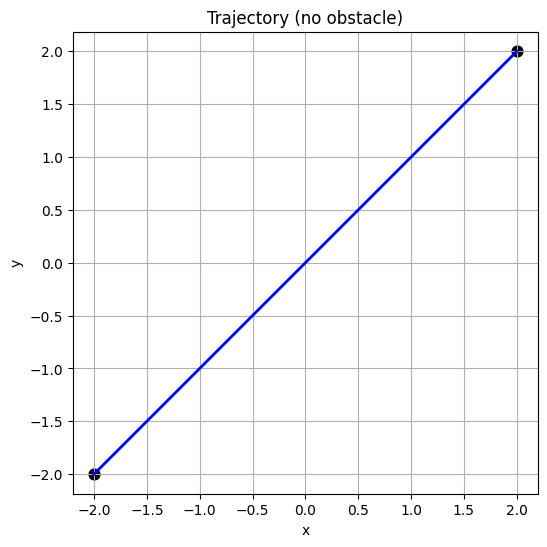

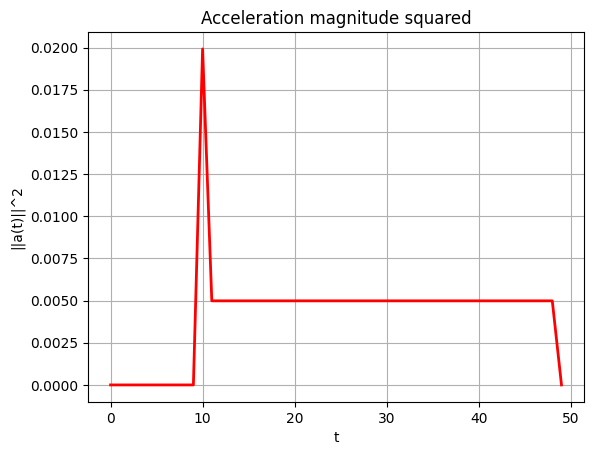

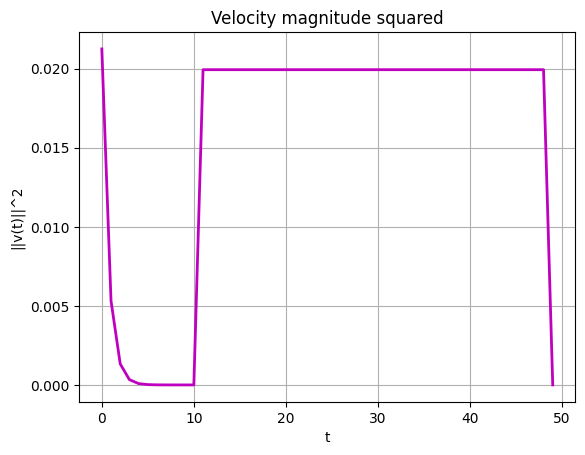

Part (b) optimal cost: 1.8398817162624808e-11
Min distance from obstacle center: 0.5545419966438011


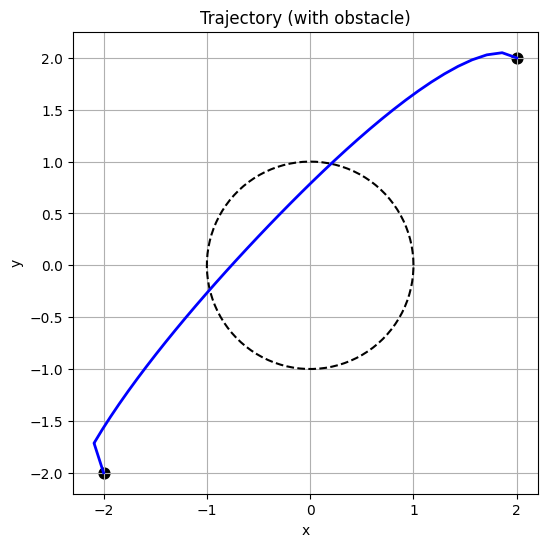

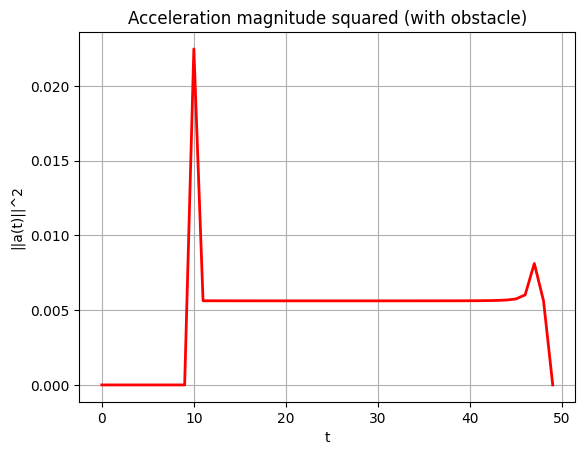

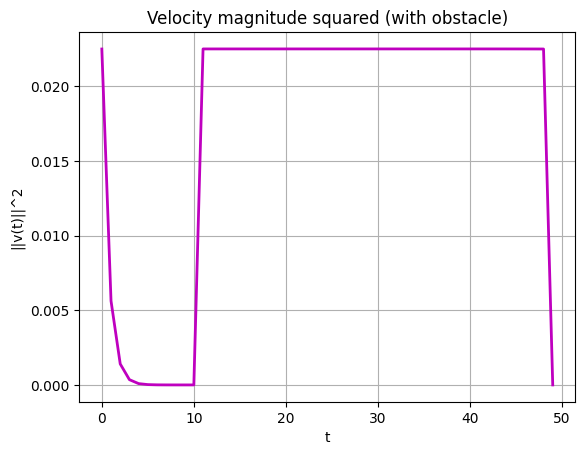

In [ ]:
# --- Drop-in Colab Script for Robot Path Optimization ---
# Installs required solver
!pip install cvxpy ecos

import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

# Parameters
T   = 50
rho = 0.5

# ---------- Part (a): No obstacle ----------
x = cp.Variable((2, T))
v = cp.Variable((2, T))
a = cp.Variable((2, T))
constraints = []

# Boundary conditions
constraints += [x[:,0] == np.array([-2, -2])]
constraints += [x[:,T-1] == np.array([2, 2])]
constraints += [v[:,T-1] == np.array([0, 0])]

# Dynamics
for t in range(T-1):
    constraints += [x[:,t+1] == x[:,t] + v[:,t]]
    constraints += [v[:,t+1] == rho * v[:,t] + a[:,t]]

# Velocity magnitude constraint
for t in range(T):
    constraints += [cp.norm(v[:,t], 2) <= 0.15]

# Objective: minimize sum of squared acceleration over first 10 steps
objective = cp.Minimize(cp.sum_squares(a[:,:10]))

# Solve
prob = cp.Problem(objective, constraints)
prob.solve(solver=cp.CLARABEL)

print("Part (a) optimal cost:", prob.value)

x_val = x.value; v_val = v.value; a_val = a.value
a_norm = np.linalg.norm(a_val, axis=0)
v_norm = np.linalg.norm(v_val, axis=0)

# Plots
plt.figure(figsize=(6,6))
plt.plot(x_val[0,:], x_val[1,:], 'b-', linewidth=2)
plt.scatter([-2,2], [-2,2], c='k', s=60)
plt.xlabel('x'); plt.ylabel('y'); plt.title('Trajectory (no obstacle)')
plt.grid(True); plt.axis('equal'); plt.show()

plt.figure(); plt.plot(a_norm**2, 'r-', linewidth=2)
plt.xlabel('t'); plt.ylabel('||a(t)||^2'); plt.title('Acceleration magnitude squared')
plt.grid(True); plt.show()

plt.figure(); plt.plot(v_norm**2, 'm-', linewidth=2)
plt.xlabel('t'); plt.ylabel('||v(t)||^2'); plt.title('Velocity magnitude squared')
plt.grid(True); plt.show()

# ---------- Part (b): With obstacle ----------
x_feas = x_val.copy()
for k in range(15):
    x = cp.Variable((2, T))
    v = cp.Variable((2, T))
    a = cp.Variable((2, T))
    constraints = []

    constraints += [x[:,0] == np.array([-2, -2])]
    constraints += [x[:,T-1] == np.array([2, 2])]
    constraints += [v[:,T-1] == np.array([0, 0])]

    for t in range(T-1):
        constraints += [x[:,t+1] == x[:,t] + v[:,t]]
        constraints += [v[:,t+1] == rho * v[:,t] + a[:,t]]

    for t in range(T):
        constraints += [cp.norm(v[:,t], 2) <= 0.15]
        constraints += [x[:,t] @ x_feas[:,t] >= np.dot(x_feas[:,t], x_feas[:,t])]

    objective = cp.Minimize(cp.sum_squares(a[:,:10]))
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.CLARABEL)
    x_feas = x.value.copy()

print("Part (b) optimal cost:", prob.value)

x_val = x.value; v_val = v.value; a_val = a.value
a_norm = np.linalg.norm(a_val, axis=0)
v_norm = np.linalg.norm(v_val, axis=0)
x_norm = np.linalg.norm(x_val, axis=0)

print("Min distance from obstacle center:", x_norm.min())

# Plots
theta = np.linspace(0, 2*np.pi, 200)
circle = np.vstack((np.cos(theta), np.sin(theta)))

plt.figure(figsize=(6,6))
plt.plot(circle[0,:], circle[1,:], 'k--', linewidth=1.5)
plt.plot(x_val[0,:], x_val[1,:], 'b-', linewidth=2)
plt.scatter([-2,2], [-2,2], c='k', s=60)
plt.xlabel('x'); plt.ylabel('y'); plt.title('Trajectory (with obstacle)')
plt.grid(True); plt.axis('equal'); plt.show()

plt.figure(); plt.plot(a_norm**2, 'r-', linewidth=2)
plt.xlabel('t'); plt.ylabel('||a(t)||^2'); plt.title('Acceleration magnitude squared (with obstacle)')
plt.grid(True); plt.show()

plt.figure(); plt.plot(v_norm**2, 'm-', linewidth=2)
plt.xlabel('t'); plt.ylabel('||v(t)||^2'); plt.title('Velocity magnitude squared (with obstacle)')
plt.grid(True); plt.show()